## Load the Required Modules

In [1]:
# Set the number of number of OMP threads to 1
%env OMP_NUM_THREADS=1

from multiprocessing import Pool
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import cirq

# Import the generator of random quantum circuits
from qflexcirq.circuits import generator
from qflexcirq import qflex

env: OMP_NUM_THREADS=1


## Define the IBM Rochester Layout

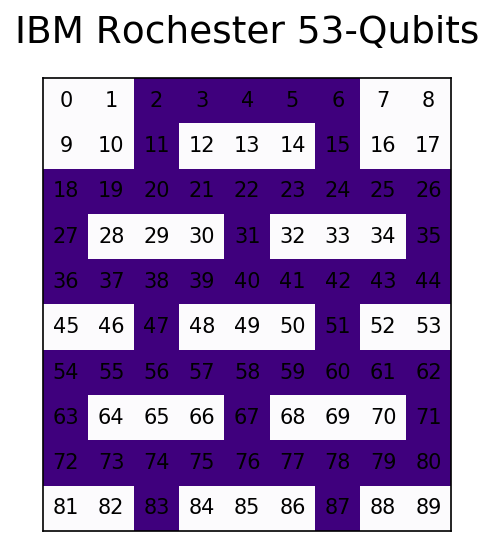

In [2]:
ibm_rochester = """001111100
001000100
111111111
100010001
111111111
001000100
111111111
100010001
111111111
001000100""".split('\n')

# Get qubits map
qubits_map = {}
for x,k in enumerate(int(y) for x in ibm_rochester for y in x):
    if k != 0:
        qubits_map[len(qubits_map)] = x

plt.rcParams['figure.dpi'] = 150
fig, ax = plt.subplots()
ax.matshow([[int(x) for x in line] for line in ibm_rochester], cmap='Purples')

count = 0
for i in range(len(ibm_rochester)):
    for j in range(len(ibm_rochester[0])):
        ax.text(j, i, count, ha='center', va='center')
        count += 1

plt.xticks([])
plt.yticks([])
plt.title('IBM Rochester 53-Qubits', fontsize=18)
plt.show()

## Specify the Ordering of the Contraction

Factors like the size of the largest intermediate tensors negatively affect the performance of qFlex. While it is always possible to provide an _ad-hoc_ ordering, qFlex library has an automated way to identify a good candidate for the ordering (see `qflexcirq.ordering`).

In [3]:
ibm_rochester_ordering = """
# NO INITIAL CUTS
#
expand p74 83
expand p74 74
expand p78 87
expand p78 78
expand A 75
merge p74 A
expand B 77
merge p78 B
expand C 55
expand C 54
expand C 63
expand C 72
expand C 73
merge C A
expand D 67
expand D 76
expand E 61
expand E 62
expand E 71
expand E 80
expand E 79
merge E B
expand F 57
expand F 56
expand F 47
expand G 59
expand G 58
expand H 51
expand H 60
expand I 19
expand I 18
expand I 27
expand I 36
expand I 37
expand I 38
expand I 39
expand J 31
expand J 40
expand K 25
expand K 26
expand K 35
expand K 44
expand K 43
expand K 42
expand K 41
expand L 20
expand M 21
expand M 22
expand M 23
expand N 24
merge A D
merge B H
merge G F
merge D F
merge H F
merge F I
merge J I
merge K I
merge M L
merge I L
merge N L
expand O 11
expand O 2
expand O 3
expand O 4
expand O 5
expand O 6
expand O 15
merge L O
"""

## Specify the Layout for Random Quantum Circuits

As for the Quantum Supremacy experiments in `Nature 574 (7779), 505-510`, we need to specify a pattern for the random quantum circuits to benchmark the IBM Rochester. In particular, we have maximized the number of parallel gates per cycle and we have made sure that every qubits interact with every neighbor every 3 cycles.

In [4]:
# Define pattern for the generation of RQCs
ibm_rochester_pattern = {
    'A': {(0, 1), (2, 3), (4, 6), (5, 9), (7, 8), (10, 11), (12, 13),
          (14, 15), (16, 19), (18, 27), (20, 21), (23, 24), (25, 26),
          (28, 32), (30, 31), (33, 34), (36, 37), (38, 41), (39, 42),
          (43, 44), (45, 46), (47, 48), (49, 50)},
    'B': {(0, 5), (1, 2), (3, 4), (6, 13), (7, 16), (9, 10), (11, 12),
          (15, 18), (17, 23), (19, 20), (21, 22), (24, 25), (26, 27),
          (29, 36), (30, 39), (32, 33), (34, 35), (37, 38), (40, 46),
          (41, 50), (42, 43), (44, 45), (48, 49)},
    'C': {(0, 5), (1, 2), (3, 4), (7, 16), (8, 9), (11, 17), (13, 14),
          (15, 18), (19, 20), (21, 28), (22, 23), (25, 29), (26, 27),
          (30, 39), (31, 32), (34, 40), (35, 36), (37, 38), (41, 50),
          (42, 43), (44, 51), (46, 47), (48, 52)},
}

# Define the sequence of patterns
ibm_rochester_sequence = "ABC"

# Define IBM Rochester gates
ibm_rochester_1q_gates = ["x_1_2", "y_1_2", "t"]
ibm_rochester_2q_gate = "cx"

In [5]:
# Get a generator of RQCs
prqcg = generator.PseudoRandomCircuitGenerator(
            generator.Device(ibm_rochester_pattern),
            ibm_rochester_1q_gates, 
            ibm_rochester_2q_gate)

def get_rqc(depth: int, seed: int = None):
    """
    Generate a Random Quantum Circuit with a given depth.
    """
  
    # Get seed if none provided
    if seed == None:
        seed = np.random.randint(2**63)

    # Get a RQC ...
    rqc = prqcg.generate(ibm_rochester_sequence, depth, seed)
  
    # ... and remap them accordingly to layout
    rqc = [' '.join([str(int(x[0])+1)]+[x[1]]+[str(qubits_map[int(y)]) for y in x[2:]]) 
            for x in (x.split() for x in rqc.to_qsim_lines())]
  
    # Add layer of hadamard at the beginning and end
    rqc = ['0 h ' + str(qubits_map[q]) for q in range(len(qubits_map))] + rqc
    rqc = rqc + [str(int(rqc[-1].split()[0])+1) + ' h ' + str(qubits_map[q]) for q in range(len(qubits_map))]
  
    # Add number of qubits at the beginning
    rqc.insert(0, str(len(qubits_map)))
  
    return rqc

## Simulate the Random Quantum Circuits

Everything is not ready to run some simulations!

In [17]:
def get_bitstrings(size: int):
    """
    Generate a set of unique bitstrings of a given size. 
    """
  
    bitstrings = {bin(np.random.randint(2**len(qubits_map)))[2:].zfill(len(qubits_map)) 
                             for _ in range(size)}
    
    while len(bitstrings) != size:
        bitstrings.add(bin(np.random.randint(2**len(qubits_map)))[2:].zfill(len(qubits_map)) 
                for _ in range(size - len(bitstrings)))
        
    return list(bitstrings)

In [7]:
# Get a random quantum circuits for a given depth
ibm_rochester_depth = 15
ibm_rochester_rqc = get_rqc(ibm_rochester_depth)

# Simulate the circuit using qFlex
def run_simulation(final_bitstring: str):

    options = {
      'circuit': ibm_rochester_rqc,
      'ordering': ibm_rochester_ordering.split('\n'),
      'grid': ibm_rochester,
      'final_state' : final_bitstring
    }
  
    return qflex.simulate(options)

Running `1000` simulations at `depth=20` should take few minutes depending on the system.

In [8]:
# Get a list of final bitstrings
final_bitstrings = get_bitstrings(1000)

results = []
with Pool(8) as pool:
    for bs in tqdm(np.array_split(final_bitstrings, int(len(final_bitstrings)/8))):
        results.extend(pool.map(run_simulation, bs))
        
# Get amplitudes
amplitudes = np.array([x[0][1] for x in results])

100%|██████████| 125/125 [03:45<00:00,  1.81s/it]


In [9]:
# We can clean-up and get a proper error bar for the 
# histogram by bootstrapping the dataset
def bootstrap_hist_data(data, num_bins=10, density=False, fraction_boostrap=0.75, bootstrap_rep=None):
    """
    Given a dataset, return a bootstrapped histogram
    """

    n = int(fraction_boostrap * len(data))
  
    if bootstrap_rep == None:
        bootstrap_rep = len(data)
  
    hist_hits, bins = np.histogram(data[[np.random.randint(len(data)) for _ in range(n)]], num_bins, density=density)
    if not density:
        hist_hits = hist_hits/len(data)
    var_hist_hits = hist_hits**2
  
    for _ in tqdm(range(bootstrap_rep-1)):
        h,b = np.histogram(data[[np.random.randint(len(data)) for _ in range(n)]], bins=bins, density=density)
        if not density:
            h = h/len(data)
  
        hist_hits += h
        var_hist_hits += h**2
  
    hist_hits = hist_hits/bootstrap_rep
    var_hist_hits = np.sqrt(var_hist_hits/bootstrap_rep - hist_hits**2)
  
    return bins, hist_hits, var_hist_hits

In [14]:
# Get probabilities
prob = np.abs(amplitudes)**2

# Get bootstrapped histogram
N = 2**(len(qubits_map))
bins, hist_hits, var_hist_hits = bootstrap_hist_data(N * prob, num_bins=16, density=True)

100%|██████████| 999/999 [00:04<00:00, 200.01it/s]


<ipython-input-15-3d23f820af38>:2: RuntimeWarning: divide by zero encountered in log
  plt.errorbar((bins[1:] + bins[:-1]) / 2., np.log(hist_hits), var_hist_hits/hist_hits, ls='--', marker='o', capsize=2)
<ipython-input-15-3d23f820af38>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.errorbar((bins[1:] + bins[:-1]) / 2., np.log(hist_hits), var_hist_hits/hist_hits, ls='--', marker='o', capsize=2)


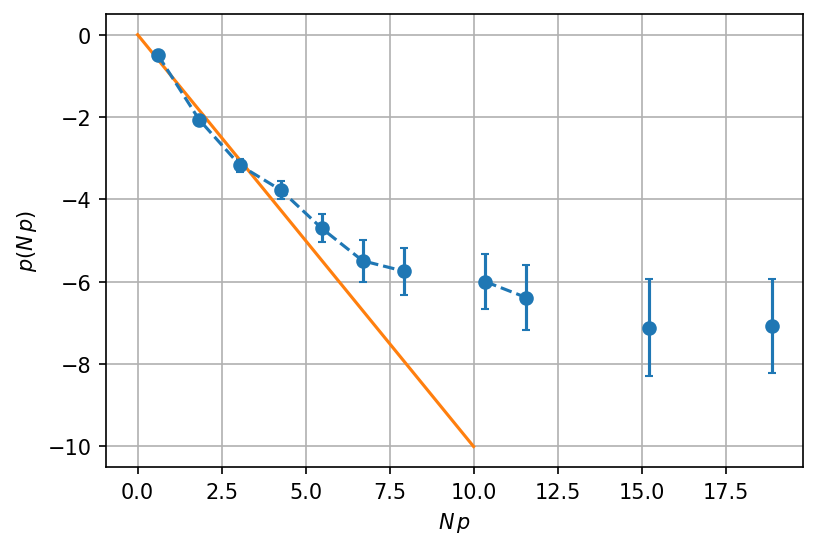

In [15]:
# Compute Porter-Thomas distribution
plt.errorbar((bins[1:] + bins[:-1]) / 2., np.log(hist_hits), var_hist_hits/hist_hits, ls='--', marker='o', capsize=2)
xs = np.linspace(0, 10, 100)
plt.plot(xs, -xs)
plt.xlabel('$N\,p$')
plt.ylabel('$p(N\,p)$')
plt.grid()
plt.show()

Even with just `1000` bitstrings, we can get a good approximation of the Porter-Thomas distribution.

In [19]:
options = {
  'circuit': get_rqc(20),
  'ordering': ibm_rochester_ordering.split('\n'),
  'grid': ibm_rochester,
  'final_state' : get_bitstrings(1)[0]
}
  
qflex.simulate(options)

[]